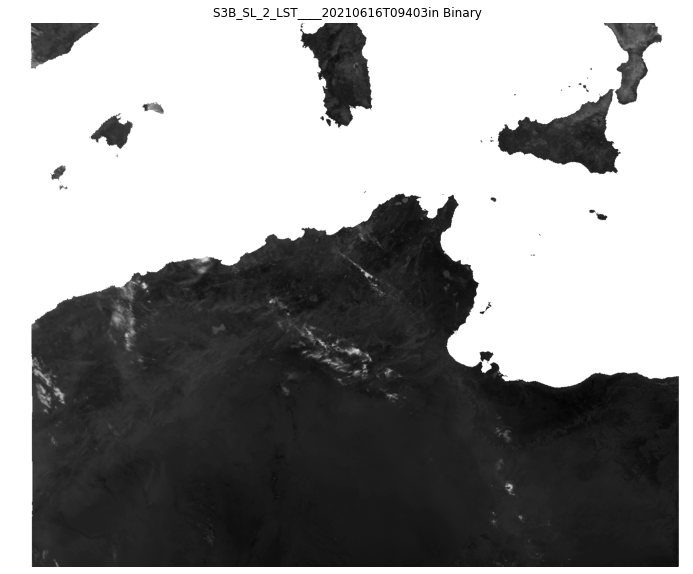

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 64, 'height': 64, 'count': 27, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.010635999999999979, 0.0, 14.067394999999973,
       0.0, -0.009772000000005221, 38.19258699999797)}


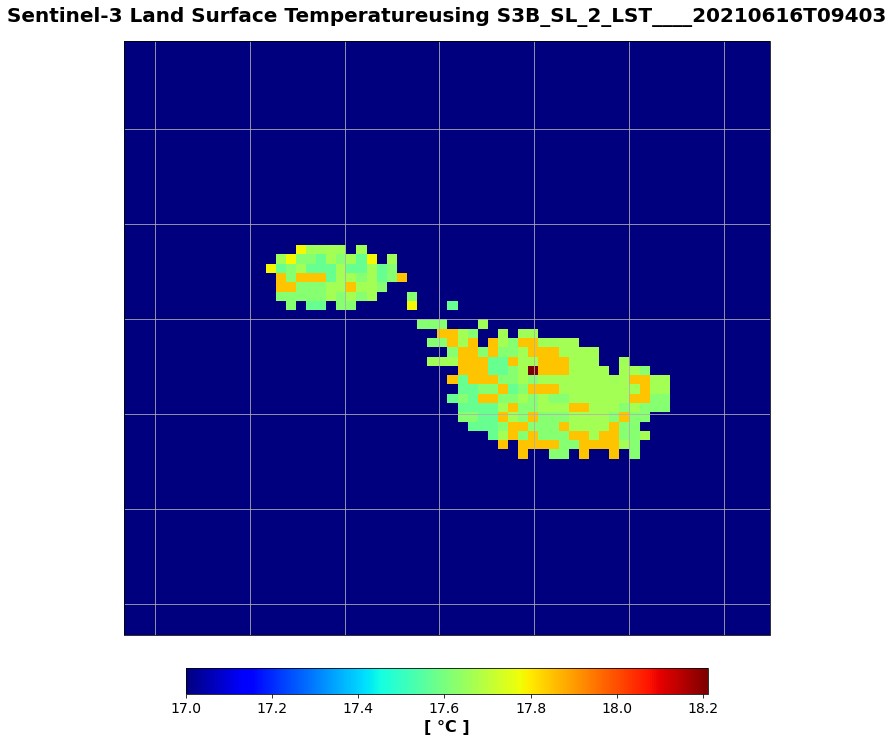

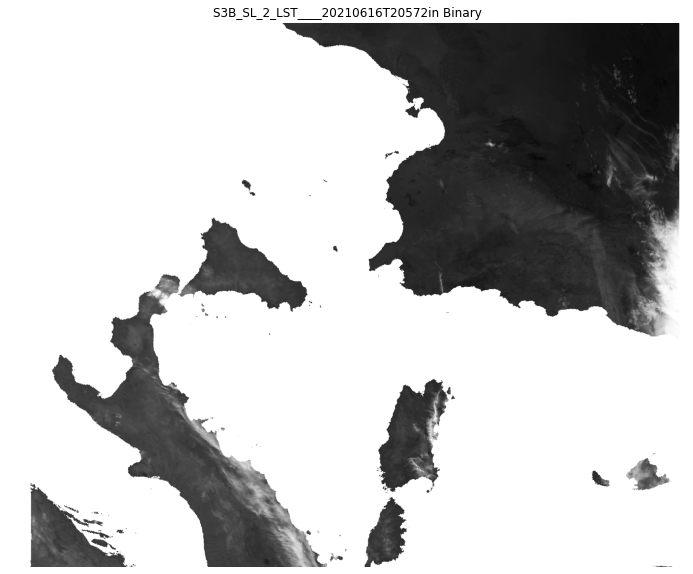

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 64, 'height': 64, 'count': 27, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.012104999999998256, 0.0, 36.11828849999779,
       0.0, -0.007531999999997652, 30.594235000000914)}


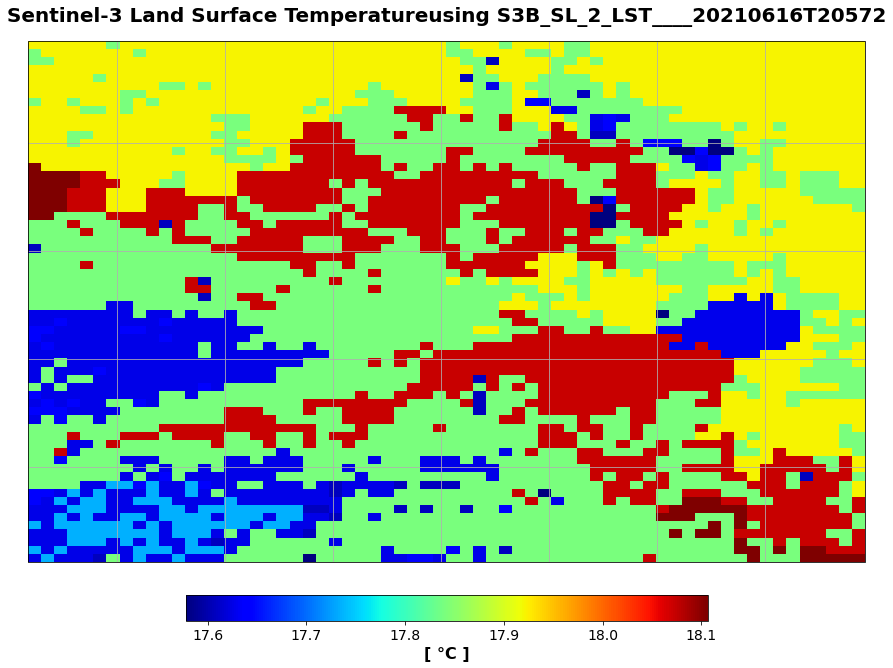

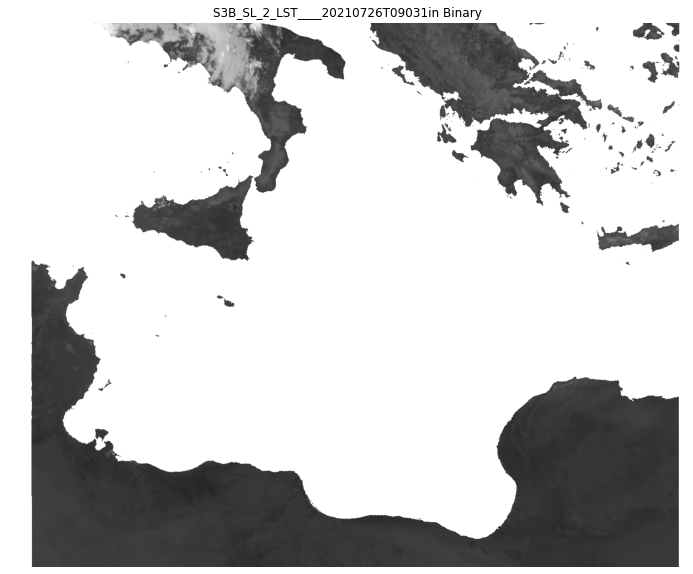

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 64, 'height': 64, 'count': 27, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.010633999999999588, 0.0, 23.421504999999478,
       0.0, -0.00977299999999559, 38.17994350000171)}


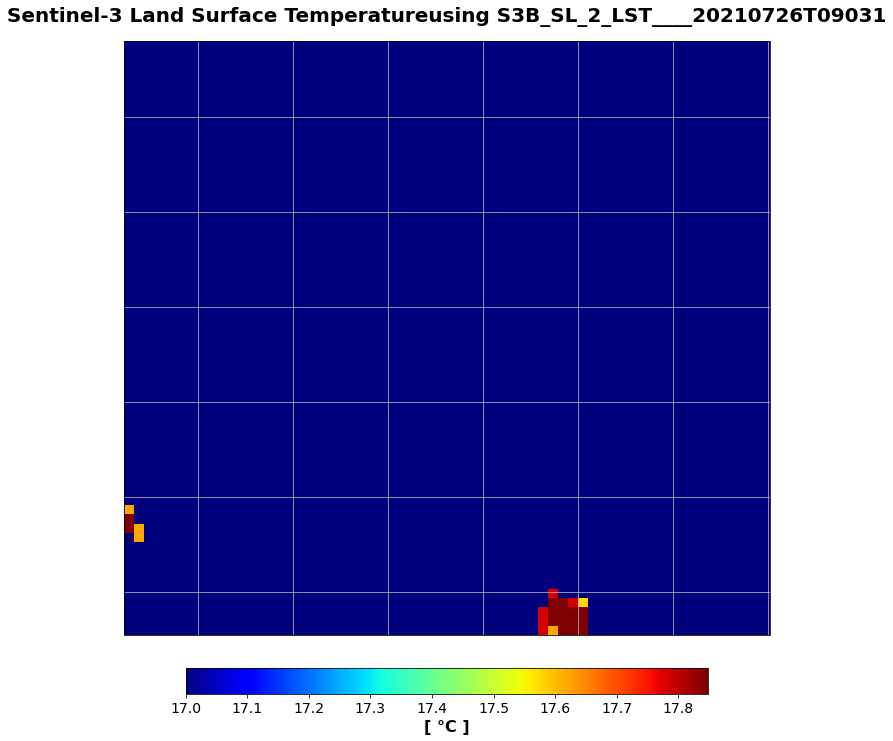

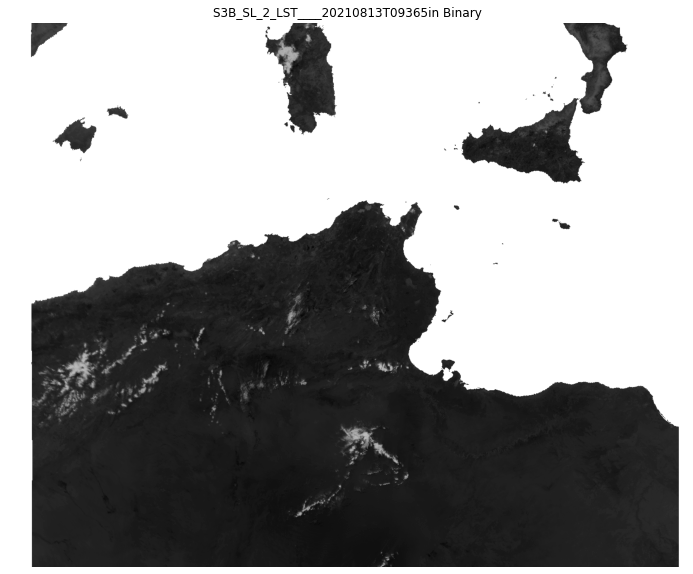

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 64, 'height': 64, 'count': 27, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.010630999999999835, 0.0, 14.99578449999979,
       0.0, -0.009772000000005221, 38.16869399999797)}


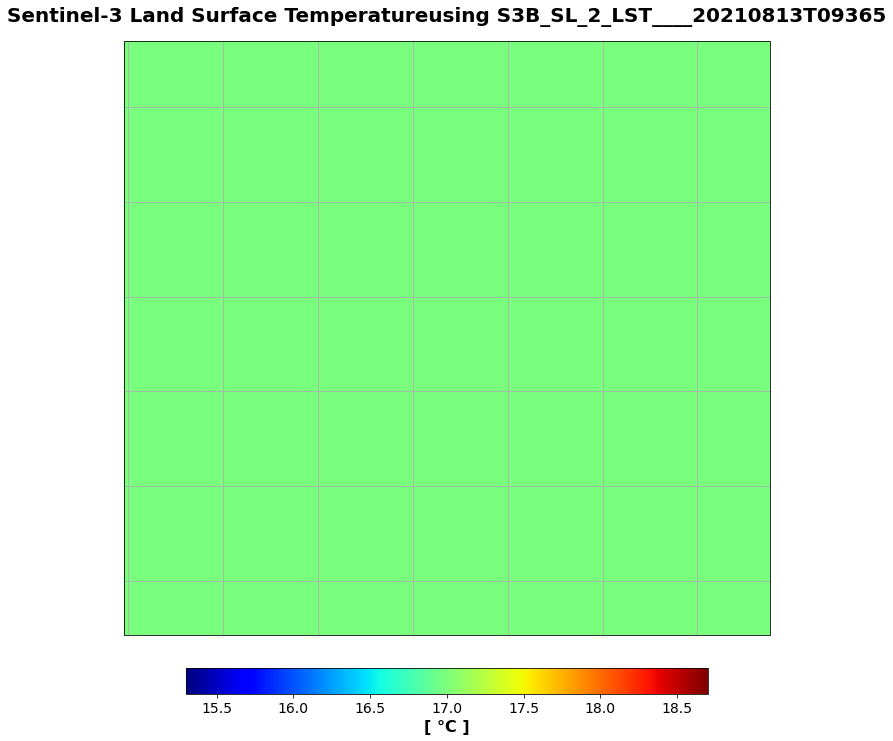

In [1]:
import os
from pathlib import Path
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import snappy
from snappy import HashMap
import gc   
from snappy import GPF
jpy = snappy.jpy
from snappy import ProductIO, File
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.enums import Resampling
import cartopy.crs as ccrs

##init variables
File = jpy.get_type('java.io.File') #file type   

pc_base_directory = ('C:/Sentinel 3 Data/') 
laptop_base_directory = ('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/2021/extra')

base_directory = laptop_base_directory
k=0
path = Path(base_directory)

## Details about Folder
full_name = []
sat = []
sensor = []
date_format = []
time_format = []

for root, dirs, files in os.walk(base_directory):
    path = root.split(os.sep)

    pathln = len(os.path.basename(root)) #len 99: end of subfolders, 94: +1, 3/5: month
    #print(pathln)

    ###pathln == 99 is how I will differentiate sentinel 3 products
    if pathln == 99:    
        ###Gathering Product details such as date & time and storing them    
        current_path = base_directory + '/'  + os.path.basename(root)
        #print(current_path)

        #string[ start_index_pos: end_index_pos: step_size]
        full_name.append(os.path.basename(root))
        #print(full_name)
        
        path_name_30chars = os.path.basename(root)[ :30] #30chars include: (0-2)Sat, (4-8)Sensor, (13-31)Type, Year, Month, Date, Time
        #print(path_name_30chars)

        sat.append(path_name_30chars[:3])
        sensor.append(path_name_30chars[4:12])

        date = path_name_30chars[16:24]
        date_format.append(date[:4] + '/' + date[4:6] + '/' + date[6:])

        time = path_name_30chars[25:29]
        time_format.append(time[:2] + ':' + time[2:])

        ###Reading product 1 at a time            
        archi=File(current_path) #product to be read
        product = ProductIO.readProduct(archi)
        reader = snappy.ProductIO.getProductReader('SEN3')
        #print('All Bands for product ' + path_name_30chars)
        #print(str(list(product.getBandNames())))

        band = product.getBand('LST') # Assign Band to a variable
        w = product.getSceneRasterWidth() # Get Band Width
        h = product.getSceneRasterHeight() # Get Band Height
        
        ##Preview progress
        # Create an empty array
        band_data = np.zeros(w * h, np.float32)
        # Populate array with pixel value
        band.readPixels(0, 0, w, h, band_data) 
        # Reshape
        band_data.shape = h, w
        # Plot the band  
        plt.figure(figsize=(18,10))

        plt.imshow(band_data, cmap = plt.cm.binary), plt.title(path_name_30chars + 'in Binary')
        plt.axis('off')
        plt.show()
        ###

        ##Write first tiff
        fullsize_tif_name = path_name_30chars + 'GeoTIFF'
        ProductIO.writeProduct(product, fullsize_tif_name, 'GeoTIFF-BigTIFF')

        ##Crop tiff to focus on malta
        cropped_tif_name = fullsize_tif_name+'_cropped.tif'

        with rasterio.open(fullsize_tif_name + '.tif') as src:
            # The size in pixels of your desired window
            #xsize, ysize = 512, 512
            xsize, ysize = 64, 64

            # Generate a random window location that doesn't go outside the image
            xmin, xmax = 0, src.width - xsize
            ymin, ymax = 0, src.height - ysize
            #xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
            xoff, yoff = 1270, 390

            # Create a Window and calculate the transform from the source dataset    
            window = Window(xoff, yoff, xsize, ysize)
            '''print('xoff: ' + str(xoff))
            print('yoff: ' + str(yoff))
            print('xsize: ' + str(xsize))
            print('ysize: ' + str(ysize))'''
            transform = src.window_transform(window)

            # Create a new cropped raster to write to
            profile = src.profile
            profile.update({
                'height': xsize,
                'width': ysize,
                'transform': transform})

            with rasterio.open(cropped_tif_name, 'w', **profile) as dst:
                # Read the data from the window and write it to the output raster
                dst.write(src.read(window=window))

        ###Visualise Crop
        raster = rasterio.open(cropped_tif_name)
        # This will print out a short version of the  meta data associated with this file.
        print(raster.meta)

        # Data visualization units.
        #unit = '[ K ]'
        unit = '[ °C ]'
        long_name = 'Sentinel-3 Land Surface Temperature' + 'using ' + path_name_30chars
        bbox = raster.bounds
        extent=[bbox[0],bbox[2],bbox[1],bbox[3]]            

        # resample data to target shape
        upscale_factor = 1
        data = raster.read(
        out_shape=(
            raster.count,
            int(raster.height * upscale_factor),
            int(raster.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )

        # scale image transform
        transform = raster.transform * raster.transform.scale(
        (raster.width / data.shape[-1]),
        (raster.height / data.shape[-2]))

        # Here we set up the parameters needed to display the geographical data correctly.
        fig=plt.figure(figsize=(15, 12))

        # Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
        #proj = ccrs.epsg(3857)
        #ax = plt.axes(projection=proj)
        ax = plt.axes(projection=ccrs.PlateCarree())

        #ax.coastlines(resolution='10m')
        ax.gridlines()
        ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

        # Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
        # selecting which colour to associate with the NODATA value in the map
        color = cm.jet
        color.set_bad('white')

        #The pixel associated to the NODATA values are masked out.
        data = data.astype(np.float16)
        data[data == -32768.0] = np.nan

        # As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
        # These can be retrieved from the extended metadata of the file. 

        scale_factor = 0.0020000001

        offset = 290

        cal_data = scale_factor * data - 273 + offset

        img = plt.imshow(cal_data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

        cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
        cbar.set_label(unit, fontsize=16, fontweight = 'bold')
        cbar.ax.tick_params(labelsize=14)
        plt.savefig(path_name_30chars+'.png')
        plt.show()
